In [1]:
from project import Projection
from Problem import Problem
from Phase1 import solve_CQ_feasible
from Phase2_1_obj import optim_Universal
from Phase2_dynamic import optim_Scalarization
from main_dynamic import load_config
from utils import visualize_pareto_front, generate_pareto_grid

In [2]:
import autograd.numpy as np
from scipy.optimize import Bounds
import matplotlib.pyplot as plt
import pandas as pd
import math
import itertools
from tqdm import tqdm

In [3]:
case = "_Ex_7_1"

# Prob

* for exact

In [4]:
def f(x):
    return np.array([
        x[0],           # f1
        (x[0] - 1)**2   # f2
    ])

def jacobian_f(x):
    return np.array([
        [1.0],              # Đạo hàm của x[0]
        [2.0 * (x[0] - 1)]  # Đạo hàm của (x[0]-1)^2
    ])

# --- Hàm mục tiêu Weighted Chebyshev (theo ảnh) ---
def S_weighted_chebyshev(x, r, z):
    vals = f(x)
    # Công thức: max( r_i * |f_i(x) - z_i| )
    weighted_diffs = r * np.abs(vals - z)
    return np.max(weighted_diffs)

# --- Tính Subgradient ---
def get_subgradient(x, r, z):
    """
    Tính đạo hàm của hàm max(r_i * |f_i - z_i|)
    """
    vals = f(x)
    diffs = vals - z
    weighted_abs_diffs = r * np.abs(diffs)
    
    # 1. Tìm chỉ số k làm hàm max đạt giá trị lớn nhất
    k = np.argmax(weighted_abs_diffs)
    
    # 2. Lấy đạo hàm của thành phần thứ k
    # Gradient = r_k * sign(diff_k) * Gradient_fk(x)
    
    J = jacobian_f(x)
    gradient_fk = J[k] # Hàng thứ k của Jacobian
    
    sign = 1.0 if diffs[k] >= 0 else -1.0
    
    grad = r[k] * sign * gradient_fk
    return grad

# ==========================================
# 2. CÁC RÀNG BUỘC & PHÉP CHIẾU (GIỮ NGUYÊN)
# ==========================================
# Ràng buộc tập X
def c1(x): return x[0]
def c2(x): return -x[0] + 1
# Ràng buộc tập Q
def q1(y): return 0.2**2 - (y[0] - 0.4)**2 - (y[1] - 0.4)**2
def q_plus(y):
    center = .4
    radius_sq = 0.2**2  
    
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)
dim_x = 1
dim_y = 2

* for dynamic

In [5]:
cons_C = (
    {'type': 'ineq', 'fun' : c1,},
    {'type': 'ineq', 'fun' : c2,}
)
cons_Q = ({'type': 'ineq', 'fun' : q1,},)
cons_Qplus = ({'type': 'ineq', 'fun': q_plus},)
# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=None, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')
# Setup Problem
prob = Problem(
    f=[f], jac_f=[jacobian_f], C=[], Q=[],
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

* config

In [6]:
base_cfg = load_config()
test_rays = base_cfg['data']['test_ray']

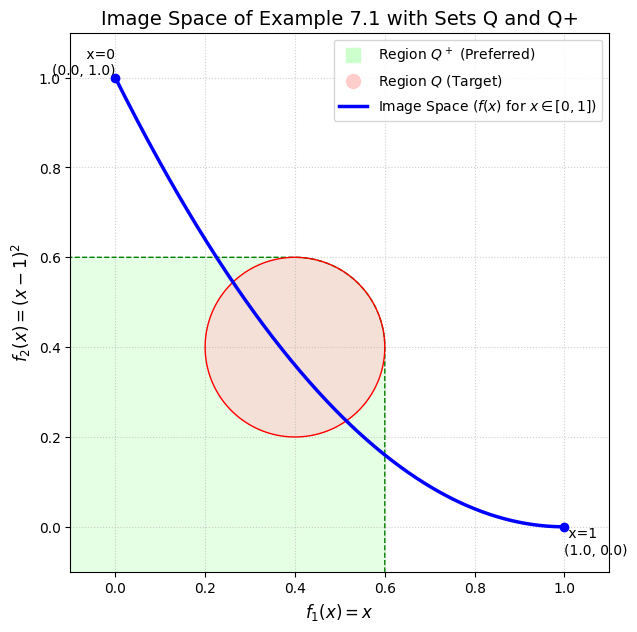

## Cloud

In [7]:
def non_c(x):
    return 1
pf_cloud, pf_targets = generate_pareto_grid(
    f_func=f, 
    c_funcs=[non_c], 
    q_plus_func=q_plus, 
    resolution=500
)

--- Đang quét lưới 500x500 điểm ---
-> Tìm thấy 250000 điểm thỏa mãn miền C.
-> Lọc còn 93500 điểm thỏa mãn Q+ (Cloud).
-> Kết quả: 187 điểm Pareto.


# Exact

In [8]:
from scipy.optimize import minimize
def project_step(x_temp, y_temp, dim_x, dim_y):
    """
    Chiếu điểm (x, y) vào tập:
    { (x, y) | x \in X, y \in Q, f(x) <= y }
    """
    z_start = np.concatenate([x_temp, y_temp])
    
    def proj_obj(z): 
        return 0.5 * np.sum((z - z_start)**2)
    
    def proj_jac(z): 
        return z - z_start

    # Danh sách ràng buộc: scipy yêu cầu dạng 'ineq' (tức là >= 0)
    cons = [
        # Ràng buộc x \in X
        {'type': 'ineq', 'fun': lambda z: c1(z[:dim_x])},
        {'type': 'ineq', 'fun': lambda z: c2(z[:dim_x])},
        # Ràng buộc y \in Q
        {'type': 'ineq', 'fun': lambda z: q1(z[dim_x:])},
        # Ràng buộc f(x) <= y  <=>  y - f(x) >= 0
        {'type': 'ineq', 'fun': lambda z: z[dim_x:] - f(z[:dim_x])}
    ]

    res = minimize(
        fun=proj_obj, x0=z_start, jac=proj_jac,
        constraints=cons, method='SLSQP',
        options={'disp': False}
    )
    
    if not res.success:
        return x_temp, y_temp
    return res.x[:dim_x], res.x[dim_x:]

# ==========================================
# 3. THUẬT TOÁN PROJECTED SUBGRADIENT DESCENT
# ==========================================

def solve_weighted_chebyshev(r_pref, z_ref, x_init, y_init, dim_x=1, dim_y=2, learning_rate=0.01, max_iters=5000, tol=1e-5):
    
    # Khởi tạo điểm bắt đầu
    x = x_init    
    y = y_init
    
    # Biến lưu giá trị hàm mục tiêu của bước trước (Khởi tạo là vô cùng)
    prev_obj_val = float('inf')
    converge = False
    
    print(f"Bắt đầu giải với r={r_pref}, z*={z_ref}")
    print(f"{'Iter':<5} | {'x':<10} | {'y vector':<15} | {'Objective':<10} | {'Active Idx'}")
    for k in range(max_iters):
        # --- BƯỚC 1: Tính Subgradient ---
        grad_x = get_subgradient(x, r_pref, z_ref)
        
        # --- BƯỚC 2: Cập nhật biến x ---
        x_temp = x - learning_rate * grad_x
        y_temp = y 
        
        # --- BƯỚC 3: Phép chiếu (Projection) ---
        x_next, y_next = project_step(x_temp, y_temp, dim_x, dim_y)
        
        # --- Tính giá trị hàm mục tiêu hiện tại ---
        obj_val = S_weighted_chebyshev(x_next, r_pref, z_ref)
        
        # --- Logging ---
        diffs = r_pref * np.abs(f(x_next) - z_ref)
        active_idx = np.argmax(diffs)
        
        if k % 2000 == 0: # In thường xuyên hơn một chút để dễ quan sát
            print(f"{k:<5} | {x_next[0]:.4f}     | [{y_next[0]:.2f}, {y_next[1]:.2f}] | {obj_val:.6f}     | f_{active_idx+1}")

        # --- BƯỚC 4: Kiểm tra điều kiện dừng (MỚI) ---
        # So sánh độ sụt giảm của hàm mục tiêu
        loss_change = abs(prev_obj_val - obj_val)
        
        if loss_change < tol:
            print(f"\n--> Hội tụ theo hàm mục tiêu tại bước {k}!")
            converge = True
            break
            
        # Cập nhật giá trị cũ cho vòng lặp sau
        prev_obj_val = obj_val
        x = x_next
        y = y_next

    return x, y, converge

<>:5: SyntaxWarning: invalid escape sequence '\i'
<>:5: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Admin\AppData\Local\Temp\ipykernel_7496\963778698.py:5: SyntaxWarning: invalid escape sequence '\i'
  { (x, y) | x \in X, y \in Q, f(x) <= y }


## z_star

In [9]:
# 1. Chạy Phase 1 (Tìm điểm khả thi ban đầu)
print("-> Đang tìm điểm Feasible (Phase 1)...")
x_feasible, _, _, _ = solve_CQ_feasible(
    prob.objective_func, prob.jacobian, prob.proj_C, prob.proj_Qplus,
    base_cfg['initialization']['x_init'],
    gamma=base_cfg['phase1']['gamma'] , max_iter=base_cfg['phase1']['max_iter']
)

print("-> Đang tìm các điểm cực trị để xác định Z* và Ref Point...")
z_vals = []
nadir_vals = []

for dim in range(2):
    # Tìm MIN
    x_min, _ = optim_Universal(prob, x_feasible, target_dim=dim, mode="min", max_iter=500, mu=0.001)
    val_min = prob.objective_func(x_min)[dim]
    z_vals.append(val_min)
    
    # Tìm MAX 
    x_max, _ = optim_Universal(prob, x_feasible, target_dim=dim, mode="max", max_iter=500, mu=0.001)
    val_max = prob.objective_func(x_max)[dim]
    nadir_vals.append(val_max)
    print(f"   Dim {dim}: Min={val_min:.4f}, Max={val_max:.4f}")
z_star = np.array(z_vals)
ref_point = np.array(nadir_vals) + np.abs(np.array(nadir_vals)) * 0.1 + 0.5 
print(f"-> Z* (Ideal): {z_star}")
print(f"-> Ref Point (HV): {ref_point}")

-> Đang tìm điểm Feasible (Phase 1)...
Khởi tạo: x0: [2.5 2.5]
Chiếu lên C được: x: [1.]


  0%|          | 7/10000 [00:00<00:30, 322.98it/s]


Hội tụ tại vòng lặp 7
+---+-------+---------+----------+------------+----------+----------+
| k | x_new | gamma_k | y        | z_proj     |   e_x    |   e_f    |
+---+-------+---------+----------+------------+----------+----------+
| 0 | [1.]  | 12.0000 | [1., 0.] | [0.6, 0. ] | 1.000000 | 0.400000 |
+---+-------+---------+----------+------------+----------+----------+
-> Đang tìm các điểm cực trị để xác định Z* và Ref Point...


   Dim 0: Min=0.1496, Max=0.8102
   Dim 1: Min=0.0797, Max=0.8240
-> Z* (Ideal): [0.1496 0.0797]
-> Ref Point (HV): [1.3912 1.4064]


## Exact loop

In [27]:
pareto_f_temp = []
learning_rate = 0.001
max_iters = 20000
x_init = np.array([0.5])
y_init = np.array([0.8, 0.5])
converge = 0
for r in test_rays:
    x, y, conv = solve_weighted_chebyshev(
        r_pref=r, z_ref=z_star, 
        dim_x=dim_x, dim_y=dim_y,
        x_init=x_init, y_init=y_init,
        learning_rate=learning_rate,
        max_iters=max_iters)
    if conv:
        converge += 1
    pareto_f_temp.append(f(x))
print(f"Converge rate = {100*converge/len(test_rays)}%")

Bắt đầu giải với r=[1. 0.], z*=[0.1496 0.0797]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 0.4990     | [0.59, 0.45] | 0.349400     | f_1

--> Hội tụ theo hàm mục tiêu tại bước 961!
Bắt đầu giải với r=[0.9966 0.0826], z*=[0.1496 0.0797]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 0.4990     | [0.59, 0.45] | 0.348210     | f_1

--> Hội tụ theo hàm mục tiêu tại bước 963!
Bắt đầu giải với r=[0.9864 0.1646], z*=[0.1496 0.0797]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 0.4990     | [0.59, 0.45] | 0.344648     | f_1

--> Hội tụ theo hàm mục tiêu tại bước 727!
Bắt đầu giải với r=[0.9694 0.2455], z*=[0.1496 0.0797]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 0.4990     | [0.59, 0.45] | 0.338738     | f_1

--> Hội tụ theo hàm mục tiêu tại bước 454!
Bắt đầu giải với r=[0.9458 0.3247], z*=[0.1496 0.0797]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 0.4991     | [

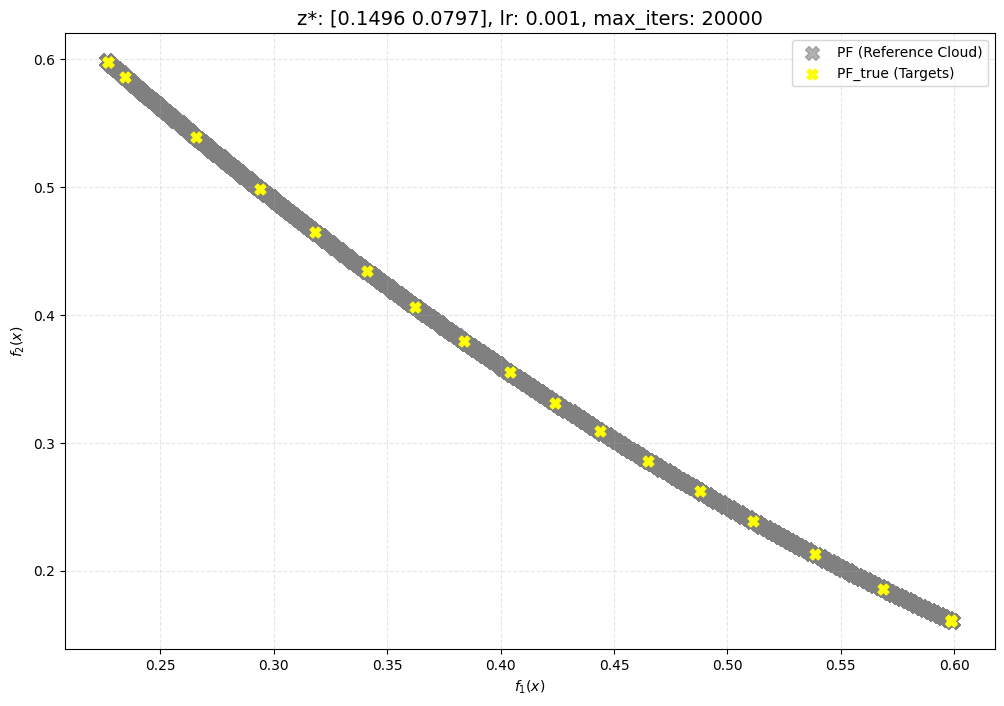

In [28]:
visualize_pareto_front(
    pf_targets=np.array(pareto_f_temp), 
    pf_cloud=pf_cloud,   
    title=f"z*: {z_star}, lr: {learning_rate}, max_iters: {max_iters}",
    figsize=(12, 8)
)

In [29]:
np.save(f"test/{case}/pf_true.npy", np.array(pareto_f_temp))

` exact OK (chọn x_init nên trung tâm của miền)` 

# Optim

In [30]:
from functions_hv_python3 import HyperVolume

def get_metrics(pareto_f, pf_true, prob, ref_point):
    """Tính toán đồng thời MED và HV"""
    pareto_f = np.array(pareto_f)
    
    # --- 1. Tính MED (Mean Error Distance) ---
    # Vì dùng chung tập test_ray nên ta tính khoảng cách cặp 1-1
    med = np.mean(np.linalg.norm(pareto_f - pf_true, axis=1))
    
    # --- 2. Tính HV (HyperVolume) ---
    valid_points = []
    tol = 1e-3
    for point in pareto_f:
        point_proj = prob.proj_Qplus(point)
        dist_Q = np.linalg.norm(point - point_proj)
        is_dominated_by_ref = np.all(point < ref_point)
        
        if dist_Q < tol and is_dominated_by_ref:
            valid_points.append(point.tolist())
            
    hv = 0.0
    if len(valid_points) >= 2:
        hv_obj = HyperVolume(ref_point)
        hv = hv_obj.compute(valid_points)
        
    return med, hv

def generate_valid_params():
    """
    Sinh các tổ hợp tham số thỏa mãn điều kiện lý thuyết hội tụ:
    1. 0.5 < expo_lambda <= 1
    2. expo_alpha > 0
    3. expo_lambda + expo_alpha <= 1 (Để đảm bảo tổng hệ số tiến về 0 đúng tốc độ) - Tuỳ chọn chặt
       Hoặc điều kiện lỏng hơn: 0 < expo_beta, expo_gamma < expo_lambda
    """
    
    # Không gian tìm kiếm thô
    grid = {
        'expo_lambda': [0.51, 0.65, 0.8],
        'expo_alpha':  [0.1, 0.25, 0.4], 
        'expo_beta':   [0.3, 0.5],
        'expo_gamma':  [0.3, 0.5],
        'init_params': [1.0, 2.0],
        'mu': [0.0001, 0.01],
        'max_iter' : [1000]
    }
    
    keys, values = zip(*grid.items())
    raw_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    valid_combinations = []
    for p in raw_combinations:
        # --- KIỂM TRA ĐIỀU KIỆN ---
        cond1 = 0.5 < p['expo_lambda'] <= 1.0
        cond2 = p['expo_lambda'] + p['expo_alpha'] <= 1
        cond3 = p['expo_beta'] < p['expo_lambda']
        cond4 = p['expo_gamma'] < p['expo_lambda']
        
        if cond1 and cond2 and cond3:
            valid_combinations.append(p)
            
    return valid_combinations

In [31]:
CHOSEN_INDICATOR = "MED"  
pf_true = np.load(f"test/{case}/pf_true.npy")

In [32]:
param_combinations = generate_valid_params()
results_log = []

print(f"=== GRID SEARCH: ƯU TIÊN {CHOSEN_INDICATOR} ===")
print(f"Số lượng cấu hình: {len(param_combinations)} | Số tia: {len(test_rays)}")

for idx, params in tqdm(enumerate(param_combinations)):
    pareto_f_temp = []
    
    # Chạy Algorithm 1-A cho từng tia với bộ params hiện tại
    for r in test_rays:
        x_final, _ = optim_Scalarization(
            prob=prob,
            x_feasible=x_feasible,  
            r=r, 
            z_star=z_star,
            verbose=False,
            **params 
        )
        pareto_f_temp.append(prob.objective_func(x_final))
    
    # Tính toán kết quả
    med, hv = get_metrics(pareto_f_temp, pf_true, prob, ref_point)
    
    log_entry = {
        'params': params,
        'MED': med,
        'HV': hv,
        'id': idx
    }
    results_log.append(log_entry)
    
    print(f"[{idx:02d}] MED: {med:.6e} | HV: {hv:.6f}")

=== GRID SEARCH: ƯU TIÊN MED ===
Số lượng cấu hình: 96 | Số tia: 20


0it [00:00, ?it/s]

Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.042902
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.000002
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032561
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.024696, Gap C: 0.000000, Gap Q: 0.000000


1it [00:46, 46.90s/it]

!! Max_iter. Delta: 0.020667, Gap C: 0.000000, Gap Q: 0.035271
[00] MED: 1.146718e-02 | HV: 1.351728
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029527, Gap C: 0.000002, Gap Q: 0.084161
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.001847, Gap C: 0.000000, Gap Q: 0.085389
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007568, Gap C: 0.000001, Gap Q: 0.032561
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

2it [01:34, 47.32s/it]

!! Max_iter. Delta: 0.020169, Gap C: 0.000000, Gap Q: 0.043708
[01] MED: 1.292085e-02 | HV: 1.346484
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.058853, Gap C: 0.000000, Gap Q: 0.042622
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029234, Gap C: 0.000002, Gap Q: 0.000157
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

3it [02:21, 47.13s/it]

!! Max_iter. Delta: 0.043944, Gap C: 0.000000, Gap Q: 0.057464
[02] MED: 1.114787e-02 | HV: 1.366224
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.059054, Gap C: 0.000002, Gap Q: 0.118595
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.005877, Gap C: 0.000000, Gap Q: 0.122931
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.058249, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029098
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000144
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

4it [03:08, 47.01s/it]

!! Max_iter. Delta: 0.038560, Gap C: 0.000000, Gap Q: 0.103049
[03] MED: 9.760306e-03 | HV: 1.346429
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010836, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

5it [03:53, 46.50s/it]

!! Max_iter. Delta: 0.023681, Gap C: 0.000000, Gap Q: 0.000000
[04] MED: 6.743041e-03 | HV: 1.346484
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.013217
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010836, Gap C: 0.000003, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

6it [04:39, 46.29s/it]

!! Max_iter. Delta: 0.022043, Gap C: 0.000000, Gap Q: 0.011964
[05] MED: 8.155023e-03 | HV: 1.346847
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.058853, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.058249, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022141, Gap C: 0.000001, Gap Q: 0.029099
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

7it [05:25, 46.21s/it]

!! Max_iter. Delta: 0.045319, Gap C: 0.000000, Gap Q: 0.000009
[06] MED: 1.080561e-02 | HV: 1.346429
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.082511
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.026697, Gap C: 0.000001, Gap Q: 0.092088
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029234, Gap C: 0.000002, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

8it [06:12, 46.25s/it]

!! Max_iter. Delta: 0.047565, Gap C: 0.000000, Gap Q: 0.000000
[07] MED: 3.886246e-03 | HV: 1.352184
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.042606
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.000004
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.025968, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, la

9it [06:58, 46.23s/it]

!! Max_iter. Delta: 0.020667, Gap C: 0.000000, Gap Q: 0.035272
[08] MED: 1.167740e-02 | HV: 1.351580
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.085233
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.001311, Gap C: 0.000000, Gap Q: 0.086172
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007568, Gap C: 0.000001, Gap Q: 0.032562
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

10it [07:44, 46.24s/it]

!! Max_iter. Delta: 0.020209, Gap C: 0.000000, Gap Q: 0.043032
[09] MED: 1.297467e-02 | HV: 1.346484
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.059054, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.004343, Gap C: 0.000000, Gap Q: 0.028134
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.058249, Gap C: 0.000002, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029234, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

11it [08:31, 46.31s/it]

!! Max_iter. Delta: 0.041259, Gap C: 0.000001, Gap Q: 0.021140
[10] MED: 2.217752e-02 | HV: 1.346429
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.118773
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.004264, Gap C: 0.000000, Gap Q: 0.125346
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

12it [09:17, 46.47s/it]

!! Max_iter. Delta: 0.038657, Gap C: 0.000000, Gap Q: 0.043170
[11] MED: 1.339344e-02 | HV: 1.346429
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.008612
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.000001
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000030
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

13it [10:03, 46.22s/it]

!! Max_iter. Delta: 0.023681, Gap C: 0.000000, Gap Q: 0.000000
[12] MED: 7.072481e-03 | HV: 1.346484
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.011595
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000008
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.027036, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

14it [10:49, 46.17s/it]

!! Max_iter. Delta: 0.022366, Gap C: 0.000000, Gap Q: 0.006506
[13] MED: 7.908444e-03 | HV: 1.346856
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.011700
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.058853, Gap C: 0.000000, Gap Q: 0.000001
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022141, Gap C: 0.000002, Gap Q: 0.029099
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

15it [11:35, 46.10s/it]

!! Max_iter. Delta: 0.047686, Gap C: 0.000000, Gap Q: 0.025781
[14] MED: 1.035342e-02 | HV: 1.346752
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.020227, Gap C: 0.000000, Gap Q: 0.006167
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

16it [12:21, 46.17s/it]

!! Max_iter. Delta: 0.048592, Gap C: 0.000002, Gap Q: 0.000000
[15] MED: 1.079080e-02 | HV: 1.346429
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.029545
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

17it [13:07, 45.98s/it]

!! Max_iter. Delta: 0.022971, Gap C: 0.000000, Gap Q: 0.000000
[16] MED: 7.139501e-03 | HV: 1.346571
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.013030
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.019442, Gap C: 0.000000, Gap Q: 0.059893
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000010
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

18it [13:53, 45.99s/it]

!! Max_iter. Delta: 0.021823, Gap C: 0.000000, Gap Q: 0.015695
[17] MED: 9.441107e-03 | HV: 1.346484
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.058853, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022141, Gap C: 0.000001, Gap Q: 0.029099
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

19it [14:39, 46.06s/it]

!! Max_iter. Delta: 0.045306, Gap C: 0.000000, Gap Q: 0.000002
[18] MED: 7.803100e-03 | HV: 1.346429
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.000044
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.042324, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

20it [15:25, 46.16s/it]

!! Max_iter. Delta: 0.048559, Gap C: 0.000000, Gap Q: 0.000000
[19] MED: 1.340384e-02 | HV: 1.346429
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029527, Gap C: 0.000002, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.026863, Gap C: 0.000000, Gap Q: 0.049270
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

21it [16:11, 46.07s/it]

!! Max_iter. Delta: 0.022561, Gap C: 0.000000, Gap Q: 0.032731
[20] MED: 5.123688e-03 | HV: 1.357324
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029527, Gap C: 0.000001, Gap Q: 0.007165
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

22it [16:57, 45.89s/it]

!! Max_iter. Delta: 0.023472, Gap C: 0.000000, Gap Q: 0.000000
[21] MED: 6.887669e-03 | HV: 1.356194
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.006859
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.055623, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.058249, Gap C: 0.000003, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

23it [17:43, 45.96s/it]

!! Max_iter. Delta: 0.049275, Gap C: 0.000000, Gap Q: 0.000000
[22] MED: 1.353348e-02 | HV: 1.358475
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.055243, Gap C: 0.000000, Gap Q: 0.050763
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000027
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

24it [18:29, 45.97s/it]

!! Max_iter. Delta: 0.044794, Gap C: 0.000000, Gap Q: 0.000001
[23] MED: 9.237222e-03 | HV: 1.350749
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029527, Gap C: 0.000001, Gap Q: 0.004483
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000001
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

25it [19:15, 45.85s/it]

!! Max_iter. Delta: 0.022971, Gap C: 0.000000, Gap Q: 0.000000
[24] MED: 9.591131e-03 | HV: 1.346484
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.012746
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.019901, Gap C: 0.000000, Gap Q: 0.059235
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

26it [20:00, 45.86s/it]

!! Max_iter. Delta: 0.021824, Gap C: 0.000000, Gap Q: 0.015676
[25] MED: 9.380891e-03 | HV: 1.346484
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.083569
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.058853, Gap C: 0.000000, Gap Q: 0.025113
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.058249, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000006
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

27it [20:47, 45.95s/it]

!! Max_iter. Delta: 0.046027, Gap C: 0.000000, Gap Q: 0.039828
[26] MED: 6.484225e-03 | HV: 1.356330
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.059054, Gap C: 0.000001, Gap Q: 0.073907
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.058853, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029234, Gap C: 0.000002, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

28it [21:32, 45.92s/it]

!! Max_iter. Delta: 0.048596, Gap C: 0.000001, Gap Q: 0.000000
[27] MED: 5.641235e-03 | HV: 1.346595
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029527, Gap C: 0.000002, Gap Q: 0.031065
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029426, Gap C: 0.000001, Gap Q: 0.044972
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.013827, Gap C: 0.000003, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

29it [22:18, 45.85s/it]

!! Max_iter. Delta: 0.023533, Gap C: 0.000001, Gap Q: 0.000000
[28] MED: 3.413851e-03 | HV: 1.363293
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029426, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032560
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

30it [23:05, 46.09s/it]

!! Max_iter. Delta: 0.023493, Gap C: 0.000000, Gap Q: 0.000000
[29] MED: 8.177365e-03 | HV: 1.350988
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.036245
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.058853, Gap C: 0.000000, Gap Q: 0.022468
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

31it [23:52, 46.31s/it]

!! Max_iter. Delta: 0.045000, Gap C: 0.000000, Gap Q: 0.000000
[30] MED: 1.417435e-02 | HV: 1.361392
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.055084, Gap C: 0.000000, Gap Q: 0.050991
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029234, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

32it [24:37, 46.13s/it]

!! Max_iter. Delta: 0.048059, Gap C: 0.000000, Gap Q: 0.022618
[31] MED: 9.510871e-03 | HV: 1.350945
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029527, Gap C: 0.000001, Gap Q: 0.014626
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.023746
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.027036, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

33it [25:23, 46.01s/it]

!! Max_iter. Delta: 0.023151, Gap C: 0.000000, Gap Q: 0.000000
[32] MED: 6.480575e-03 | HV: 1.346885
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029426, Gap C: 0.000002, Gap Q: 0.006123
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032560
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000004
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

34it [26:09, 45.94s/it]

!! Max_iter. Delta: 0.023981, Gap C: 0.000000, Gap Q: 0.000000
[33] MED: 5.446094e-03 | HV: 1.346864
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.059054, Gap C: 0.000001, Gap Q: 0.000002
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.058853, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.028208, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

35it [26:55, 45.93s/it]

!! Max_iter. Delta: 0.049734, Gap C: 0.000002, Gap Q: 0.000000
[34] MED: 7.987655e-03 | HV: 1.361366
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.058853, Gap C: 0.000000, Gap Q: 0.009065
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029098
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

36it [27:41, 45.97s/it]

!! Max_iter. Delta: 0.043114, Gap C: 0.000000, Gap Q: 0.064490
[35] MED: 1.340402e-02 | HV: 1.366907
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.037309
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.038463
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

37it [28:26, 45.84s/it]

!! Max_iter. Delta: 0.023053, Gap C: 0.000000, Gap Q: 0.000005
[36] MED: 5.228809e-03 | HV: 1.349501
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029527, Gap C: 0.000001, Gap Q: 0.008621
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.012753
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000014
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.025968, Gap C: 0.000002, Gap Q: 0.000000
Params: alpha=k^-0.4, la

38it [29:12, 45.76s/it]

!! Max_iter. Delta: 0.024338, Gap C: 0.000001, Gap Q: 0.002641
[37] MED: 7.952389e-03 | HV: 1.360381
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.059054, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.055887, Gap C: 0.000001, Gap Q: 0.049843
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

39it [29:58, 45.92s/it]

!! Max_iter. Delta: 0.045295, Gap C: 0.000000, Gap Q: 0.000000
[38] MED: 1.696434e-02 | HV: 1.346796
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.058853, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

40it [30:44, 45.90s/it]

!! Max_iter. Delta: 0.047252, Gap C: 0.000000, Gap Q: 0.029458
[39] MED: 9.852340e-03 | HV: 1.354908
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.012929
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.025355
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.013827, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.027036, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

41it [31:30, 45.81s/it]

!! Max_iter. Delta: 0.022724, Gap C: 0.000000, Gap Q: 0.000442
[40] MED: 6.465552e-03 | HV: 1.346904
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029527, Gap C: 0.000001, Gap Q: 0.001588
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.006729
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.013827, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

42it [32:15, 45.79s/it]

!! Max_iter. Delta: 0.023974, Gap C: 0.000000, Gap Q: 0.000019
[41] MED: 6.721568e-03 | HV: 1.367648
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.000089
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.043323, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.058249, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000020
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

43it [33:01, 45.87s/it]

!! Max_iter. Delta: 0.049894, Gap C: 0.000001, Gap Q: 0.007085
[42] MED: 1.276938e-02 | HV: 1.346659
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.058853, Gap C: 0.000000, Gap Q: 0.009327
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.058249, Gap C: 0.000004, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

44it [33:47, 45.91s/it]

!! Max_iter. Delta: 0.044862, Gap C: 0.000000, Gap Q: 0.049687
[43] MED: 1.256109e-02 | HV: 1.361554
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.002693
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029426, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010836, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.013827, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

45it [34:33, 45.76s/it]

!! Max_iter. Delta: 0.023210, Gap C: 0.000000, Gap Q: 0.021735
[44] MED: 5.379663e-03 | HV: 1.369260
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029527, Gap C: 0.000000, Gap Q: 0.019005
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029426, Gap C: 0.000001, Gap Q: 0.002162
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007568, Gap C: 0.000000, Gap Q: 0.032562
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010836, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.013827, Gap C: 0.000002, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.027036, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.025968, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

46it [35:18, 45.68s/it]

!! Max_iter. Delta: 0.024309, Gap C: 0.000001, Gap Q: 0.003117
[45] MED: 7.511026e-03 | HV: 1.360913
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.025636
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.051492, Gap C: 0.000000, Gap Q: 0.056130
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000002
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.051891, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, la

47it [36:04, 45.77s/it]

!! Max_iter. Delta: 0.043841, Gap C: 0.000000, Gap Q: 0.000002
[46] MED: 1.409769e-02 | HV: 1.347041
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.059054, Gap C: 0.000000, Gap Q: 0.022046
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.058853, Gap C: 0.000000, Gap Q: 0.026544
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.058249, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022141, Gap C: 0.000000, Gap Q: 0.029099
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.028208, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.029234, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.51, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.051891, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.4, la

48it [36:50, 45.77s/it]

!! Max_iter. Delta: 0.046156, Gap C: 0.000000, Gap Q: 0.038736
[47] MED: 1.330521e-02 | HV: 1.354065
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.043818
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.011189, Gap C: 0.000000, Gap Q: 0.025229
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.011074, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.004078, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010282, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007100, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

49it [37:36, 45.79s/it]

!! Max_iter. Delta: 0.008040, Gap C: 0.000000, Gap Q: 0.036337
[48] MED: 1.850863e-02 | HV: 1.336310
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.038692
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.003586, Gap C: 0.000000, Gap Q: 0.056477
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.004078, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007100, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

50it [38:22, 45.79s/it]

!! Max_iter. Delta: 0.007876, Gap C: 0.000000, Gap Q: 0.054865
[49] MED: 1.940405e-02 | HV: 1.336310
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022455, Gap C: 0.000000, Gap Q: 0.072037
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022378, Gap C: 0.000000, Gap Q: 0.040574
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.005744, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010465, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

51it [39:08, 45.85s/it]

!! Max_iter. Delta: 0.015850, Gap C: 0.000000, Gap Q: 0.035845
[50] MED: 3.185471e-02 | HV: 1.336802
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022455, Gap C: 0.000000, Gap Q: 0.072591
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.004526, Gap C: 0.000000, Gap Q: 0.034952
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.005744, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

52it [39:54, 45.90s/it]

!! Max_iter. Delta: 0.015487, Gap C: 0.000000, Gap Q: 0.043924
[51] MED: 3.600922e-02 | HV: 1.336802
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.001202
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.011189, Gap C: 0.000000, Gap Q: 0.000003
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.000046
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.004078, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007100, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

53it [40:39, 45.87s/it]

!! Max_iter. Delta: 0.008758, Gap C: 0.000000, Gap Q: 0.015577
[52] MED: 1.039071e-02 | HV: 1.336310
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.000007
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.011189, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.004078, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007100, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

54it [41:25, 45.76s/it]

!! Max_iter. Delta: 0.008592, Gap C: 0.000001, Gap Q: 0.011755
[53] MED: 1.288277e-02 | HV: 1.336310
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022455, Gap C: 0.000002, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022378, Gap C: 0.000001, Gap Q: 0.015474
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.005744, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

55it [42:10, 45.65s/it]

!! Max_iter. Delta: 0.017612, Gap C: 0.000000, Gap Q: 0.019074
[54] MED: 2.511411e-02 | HV: 1.361443
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022455, Gap C: 0.000001, Gap Q: 0.030672
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022378, Gap C: 0.000000, Gap Q: 0.028447
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.005744, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.021768, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010465, Gap C: 0.000002, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

56it [42:56, 45.55s/it]

!! Max_iter. Delta: 0.017905, Gap C: 0.000000, Gap Q: 0.012548
[55] MED: 2.378608e-02 | HV: 1.363427
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.043817
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.011189, Gap C: 0.000000, Gap Q: 0.025228
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.004078, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007100, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

57it [43:41, 45.58s/it]

!! Max_iter. Delta: 0.008040, Gap C: 0.000000, Gap Q: 0.036337
[56] MED: 1.850863e-02 | HV: 1.336310
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.038721
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003502, Gap C: 0.000000, Gap Q: 0.056598
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.004078, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007100, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

58it [44:27, 45.54s/it]

!! Max_iter. Delta: 0.007878, Gap C: 0.000000, Gap Q: 0.054797
[57] MED: 1.937288e-02 | HV: 1.336310
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022455, Gap C: 0.000000, Gap Q: 0.064944
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022378, Gap C: 0.000003, Gap Q: 0.040574
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.005744, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

59it [45:13, 45.60s/it]

!! Max_iter. Delta: 0.015850, Gap C: 0.000000, Gap Q: 0.035846
[58] MED: 3.144739e-02 | HV: 1.336802
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022455, Gap C: 0.000001, Gap Q: 0.075345
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003078, Gap C: 0.000000, Gap Q: 0.036992
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.005744, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.021768, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

60it [45:58, 45.63s/it]

!! Max_iter. Delta: 0.015477, Gap C: 0.000000, Gap Q: 0.044151
[59] MED: 3.624195e-02 | HV: 1.336802
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.000008
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.011189, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.004078, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010619, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007100, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, la

61it [46:44, 45.66s/it]

!! Max_iter. Delta: 0.008758, Gap C: 0.000000, Gap Q: 0.015577
[60] MED: 1.039071e-02 | HV: 1.336310
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.011227, Gap C: 0.000001, Gap Q: 0.000017
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.011189, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.004078, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007100, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

62it [47:30, 45.65s/it]

!! Max_iter. Delta: 0.008587, Gap C: 0.000000, Gap Q: 0.011982
[61] MED: 1.289340e-02 | HV: 1.336310
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022455, Gap C: 0.000000, Gap Q: 0.028781
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022378, Gap C: 0.000000, Gap Q: 0.012395
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.005744, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

63it [48:15, 45.64s/it]

!! Max_iter. Delta: 0.017839, Gap C: 0.000000, Gap Q: 0.000000
[62] MED: 2.493934e-02 | HV: 1.348227
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022455, Gap C: 0.000000, Gap Q: 0.024816
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022378, Gap C: 0.000000, Gap Q: 0.030816
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.005744, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.020564, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, la

64it [49:01, 45.64s/it]

!! Max_iter. Delta: 0.017907, Gap C: 0.000000, Gap Q: 0.012486
[63] MED: 2.381891e-02 | HV: 1.363497
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.018814
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.011189, Gap C: 0.000001, Gap Q: 0.000935
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.004078, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007100, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

65it [49:47, 45.67s/it]

!! Max_iter. Delta: 0.008551, Gap C: 0.000000, Gap Q: 0.024806
[64] MED: 1.088211e-02 | HV: 1.336310
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.013379
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.011189, Gap C: 0.000000, Gap Q: 0.030749
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.004078, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007100, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-

66it [50:32, 45.66s/it]

!! Max_iter. Delta: 0.008498, Gap C: 0.000000, Gap Q: 0.015949
[65] MED: 1.364567e-02 | HV: 1.336310
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022455, Gap C: 0.000000, Gap Q: 0.033388
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022378, Gap C: 0.000000, Gap Q: 0.038280
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.005744, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

67it [51:18, 45.66s/it]

!! Max_iter. Delta: 0.017631, Gap C: 0.000000, Gap Q: 0.000000
[66] MED: 2.637981e-02 | HV: 1.350451
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022455, Gap C: 0.000000, Gap Q: 0.020861
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.022378, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.005744, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

68it [52:03, 45.61s/it]

!! Max_iter. Delta: 0.017042, Gap C: 0.000000, Gap Q: 0.031758
[67] MED: 2.580276e-02 | HV: 1.344167
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.011189, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.001040
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.004078, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010282, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007100, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

69it [52:49, 45.53s/it]

!! Max_iter. Delta: 0.008859, Gap C: 0.000000, Gap Q: 0.000008
[68] MED: 1.118688e-02 | HV: 1.336310
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.011189, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.011074, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.004078, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007100, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

70it [53:34, 45.49s/it]

!! Max_iter. Delta: 0.008859, Gap C: 0.000000, Gap Q: 0.000016
[69] MED: 1.026278e-02 | HV: 1.356570
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022455, Gap C: 0.000000, Gap Q: 0.031225
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022378, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.005744, Gap C: 0.000002, Gap Q: 0.000164
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

71it [54:20, 45.51s/it]

!! Max_iter. Delta: 0.017261, Gap C: 0.000000, Gap Q: 0.004426
[70] MED: 2.659923e-02 | HV: 1.360624
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022455, Gap C: 0.000000, Gap Q: 0.012839
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.022378, Gap C: 0.000000, Gap Q: 0.021519
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.005744, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.020564, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.014320, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-

72it [55:05, 45.45s/it]

!! Max_iter. Delta: 0.018252, Gap C: 0.000001, Gap Q: 0.004813
[71] MED: 2.549880e-02 | HV: 1.360555
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.018832
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.011189, Gap C: 0.000000, Gap Q: 0.000933
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.004078, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007100, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

73it [55:51, 45.55s/it]

!! Max_iter. Delta: 0.008551, Gap C: 0.000001, Gap Q: 0.024806
[72] MED: 1.135716e-02 | HV: 1.336310
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.013291
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010861, Gap C: 0.000002, Gap Q: 0.030661
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.004078, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007100, Gap C: 0.000002, Gap Q: 0.000000
Params: alpha=k^-

74it [56:37, 45.65s/it]

!! Max_iter. Delta: 0.008498, Gap C: 0.000000, Gap Q: 0.015951
[73] MED: 1.364102e-02 | HV: 1.336310
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022455, Gap C: 0.000000, Gap Q: 0.032657
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022378, Gap C: 0.000000, Gap Q: 0.017318
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.005744, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010465, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.014320, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-

75it [57:22, 45.61s/it]

!! Max_iter. Delta: 0.017662, Gap C: 0.000000, Gap Q: 0.000820
[74] MED: 2.698060e-02 | HV: 1.350192
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022455, Gap C: 0.000000, Gap Q: 0.015060
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.022378, Gap C: 0.000000, Gap Q: 0.000047
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.005744, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.021768, Gap C: 0.000002, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

76it [58:08, 45.59s/it]

!! Max_iter. Delta: 0.017041, Gap C: 0.000000, Gap Q: 0.031772
[75] MED: 2.616511e-02 | HV: 1.341170
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.000001
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.011189, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.011074, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.004078, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007100, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

77it [58:53, 45.55s/it]

!! Max_iter. Delta: 0.008859, Gap C: 0.000000, Gap Q: 0.000000
[76] MED: 1.116643e-02 | HV: 1.336310
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.011227, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.011189, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.011074, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.004078, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010619, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010282, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007100, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-

78it [59:39, 45.53s/it]

!! Max_iter. Delta: 0.008859, Gap C: 0.000000, Gap Q: 0.000001
[77] MED: 1.038434e-02 | HV: 1.356061
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022455, Gap C: 0.000000, Gap Q: 0.005805
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022378, Gap C: 0.000000, Gap Q: 0.021106
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.005744, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

79it [1:00:24, 45.53s/it]

!! Max_iter. Delta: 0.017668, Gap C: 0.000004, Gap Q: 0.000018
[78] MED: 2.693041e-02 | HV: 1.354428
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022455, Gap C: 0.000001, Gap Q: 0.000002
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.022378, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.005744, Gap C: 0.000003, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.021768, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.010465, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.020564, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.25, lambda=k^-0.65, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.014320, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-

80it [1:01:10, 45.51s/it]

!! Max_iter. Delta: 0.018084, Gap C: 0.000000, Gap Q: 0.008562
[79] MED: 2.794973e-02 | HV: 1.348516
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.003984, Gap C: 0.000000, Gap Q: 0.037687
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.003971, Gap C: 0.000000, Gap Q: 0.043028
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.003930, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.003862, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.001833, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.002188, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.003504, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

81it [1:01:55, 45.57s/it]

!! Max_iter. Delta: 0.002824, Gap C: 0.000000, Gap Q: 0.043567
[80] MED: 1.531115e-02 | HV: 1.349319
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.003984, Gap C: 0.000001, Gap Q: 0.038537
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.003971, Gap C: 0.000000, Gap Q: 0.038541
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.003930, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.003862, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.001833, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.002188, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.003504, Gap C: 0.000002, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

82it [1:02:41, 45.61s/it]

!! Max_iter. Delta: 0.002823, Gap C: 0.000000, Gap Q: 0.047680
[81] MED: 1.567259e-02 | HV: 1.349319
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007969, Gap C: 0.000001, Gap Q: 0.051232
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007941, Gap C: 0.000000, Gap Q: 0.043326
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.002019, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007725, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007537, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007297, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007008, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

83it [1:03:27, 45.71s/it]

!! Max_iter. Delta: 0.005704, Gap C: 0.000000, Gap Q: 0.046098
[82] MED: 1.883467e-02 | HV: 1.370433
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007969, Gap C: 0.000000, Gap Q: 0.051243
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.004247, Gap C: 0.000000, Gap Q: 0.038090
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.002019, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007725, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007537, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007297, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.3
!! Max_iter. Delta: 0.007008, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

84it [1:04:13, 45.76s/it]

!! Max_iter. Delta: 0.005606, Gap C: 0.000000, Gap Q: 0.044225
[83] MED: 2.146958e-02 | HV: 1.370433
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.003984, Gap C: 0.000000, Gap Q: 0.008514
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.003971, Gap C: 0.000000, Gap Q: 0.007052
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.003930, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.003862, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.001833, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.002188, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.003504, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

85it [1:04:59, 45.87s/it]

!! Max_iter. Delta: 0.003100, Gap C: 0.000000, Gap Q: 0.008953
[84] MED: 8.222327e-03 | HV: 1.349319
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.003984, Gap C: 0.000000, Gap Q: 0.015993
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.003971, Gap C: 0.000000, Gap Q: 0.009620
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.003930, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.003862, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.001833, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.002188, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.003504, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

86it [1:05:45, 45.87s/it]

!! Max_iter. Delta: 0.003076, Gap C: 0.000000, Gap Q: 0.011941
[85] MED: 8.142972e-03 | HV: 1.349319
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007969, Gap C: 0.000000, Gap Q: 0.010750
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007941, Gap C: 0.000000, Gap Q: 0.002291
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.002019, Gap C: 0.000000, Gap Q: 0.000123
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007725, Gap C: 0.000000, Gap Q: 0.000002
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007537, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007297, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007008, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

87it [1:06:31, 45.86s/it]

!! Max_iter. Delta: 0.006214, Gap C: 0.000000, Gap Q: 0.006106
[86] MED: 1.224239e-02 | HV: 1.370445
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007969, Gap C: 0.000000, Gap Q: 0.021129
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007941, Gap C: 0.000001, Gap Q: 0.011845
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.002019, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007725, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007537, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007297, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
!! Max_iter. Delta: 0.007008, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

88it [1:07:17, 45.86s/it]

!! Max_iter. Delta: 0.006119, Gap C: 0.000000, Gap Q: 0.020032
[87] MED: 1.220160e-02 | HV: 1.370800
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003984, Gap C: 0.000000, Gap Q: 0.037687
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003971, Gap C: 0.000000, Gap Q: 0.034350
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003930, Gap C: 0.000003, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003862, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.001833, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.002188, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003504, Gap C: 0.000003, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

89it [1:08:02, 45.83s/it]

!! Max_iter. Delta: 0.002827, Gap C: 0.000000, Gap Q: 0.047189
[88] MED: 1.528393e-02 | HV: 1.349319
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003984, Gap C: 0.000000, Gap Q: 0.038721
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003971, Gap C: 0.000000, Gap Q: 0.038439
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003930, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003862, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.001833, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.002188, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003504, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

90it [1:08:48, 45.83s/it]

!! Max_iter. Delta: 0.002823, Gap C: 0.000000, Gap Q: 0.047669
[89] MED: 1.566127e-02 | HV: 1.349319
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007969, Gap C: 0.000002, Gap Q: 0.046720
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007941, Gap C: 0.000000, Gap Q: 0.043326
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.002019, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007725, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007537, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007297, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007008, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

91it [1:09:34, 45.84s/it]

!! Max_iter. Delta: 0.005704, Gap C: 0.000001, Gap Q: 0.046097
[90] MED: 1.857104e-02 | HV: 1.370433
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007969, Gap C: 0.000000, Gap Q: 0.051483
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.003766, Gap C: 0.000000, Gap Q: 0.038771
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.002019, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007725, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007537, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007297, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
!! Max_iter. Delta: 0.007008, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

92it [1:10:20, 45.85s/it]

!! Max_iter. Delta: 0.005607, Gap C: 0.000000, Gap Q: 0.044182
[91] MED: 2.152993e-02 | HV: 1.370433
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.003984, Gap C: 0.000000, Gap Q: 0.008514
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.003971, Gap C: 0.000000, Gap Q: 0.007053
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.003930, Gap C: 0.000000, Gap Q: 0.000003
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.003862, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.001833, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.002188, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.003504, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

93it [1:11:06, 45.93s/it]

!! Max_iter. Delta: 0.003100, Gap C: 0.000000, Gap Q: 0.008953
[92] MED: 7.947349e-03 | HV: 1.349319
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.003984, Gap C: 0.000000, Gap Q: 0.015401
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.003971, Gap C: 0.000000, Gap Q: 0.009836
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.003930, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.003862, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.001833, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.002188, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.003504, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

94it [1:11:52, 45.93s/it]

!! Max_iter. Delta: 0.003080, Gap C: 0.000000, Gap Q: 0.011523
[93] MED: 8.126345e-03 | HV: 1.349319
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007969, Gap C: 0.000000, Gap Q: 0.010781
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007941, Gap C: 0.000000, Gap Q: 0.016652
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.002019, Gap C: 0.000000, Gap Q: 0.000002
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007725, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007537, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007297, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007008, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

95it [1:12:38, 45.98s/it]

!! Max_iter. Delta: 0.006214, Gap C: 0.000001, Gap Q: 0.006105
[94] MED: 1.162052e-02 | HV: 1.370444
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007969, Gap C: 0.000000, Gap Q: 0.022300
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007941, Gap C: 0.000000, Gap Q: 0.021836
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.002019, Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007725, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007537, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007297, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
!! Max_iter. Delta: 0.007008, Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^

96it [1:13:24, 45.88s/it]

!! Max_iter. Delta: 0.006125, Gap C: 0.000000, Gap Q: 0.019650
[95] MED: 1.283054e-02 | HV: 1.370433


In [33]:
if CHOSEN_INDICATOR == "MED":
    best_entry = min(results_log, key=lambda x: x['MED'])
elif CHOSEN_INDICATOR == "HV":
    best_entry = max(results_log, key=lambda x: x['HV'])
else:
    raise ValueError("Indicator phải là 'MED' hoặc 'HV'")

print("\n" + "="*60)
print(f"CẤU HÌNH TỐI ƯU NHẤT THEO {CHOSEN_INDICATOR}:")
print(f"ID: {best_entry['id']}")
print(f"MED: {best_entry['MED']:.8f}")
print(f"HV:  {best_entry['HV']:.8f}")
print(f"Params: {best_entry['params']}")
print("="*60)

# Lưu kết quả tốt nhất để sử dụng cho các bước sau
best_params = best_entry['params']


CẤU HÌNH TỐI ƯU NHẤT THEO MED:
ID: 28
MED: 0.00341385
HV:  1.36329257
Params: {'expo_lambda': 0.51, 'expo_alpha': 0.25, 'expo_beta': 0.5, 'expo_gamma': 0.5, 'init_params': 1.0, 'mu': 0.0001, 'max_iter': 1000}


In [35]:
import pandas as pd
df = pd.json_normalize(results_log, sep='_')
df.columns = df.columns.str.replace('params_', '')
df.to_csv(f"exp/{case}.csv", index=False)

In [36]:
pd.read_csv('exp/_Ex_7_1.csv.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'exp/_Ex_7_1.csv.csv'

In [ ]:
pareto_f_temp = []
for r in test_rays:
        x_final, _ = optim_Scalarization(
            prob=prob,
            x_feasible=x_feasible,  
            r=r, 
            z_star=z_star,
            # Các tham số tĩnh
            max_iter=base_cfg['phase2']['max_iter'],
            mu=base_cfg['phase2']['mu'],
            verbose=True,
            # --- CÁC THAM SỐ ĐANG TỐI ƯU ---
            init_params=best_params['init_params'],
            expo_alpha=best_params['expo_alpha'],
            expo_lambda=best_params['expo_lambda'],
            expo_beta=best_params['expo_beta'],
            expo_gamma=best_params['expo_gamma'],
        )
        pareto_f_temp.append(prob.objective_func(x_final))
    
    # Tính HV


In [ ]:
med, hv = get_metrics(pareto_f_temp, pf_true, prob, ref_point)
med, hv 

In [ ]:
np.save(f"test/{case}/pf_dynamic_true.npy", pareto_f_temp)

In [ ]:
visualize_pareto_front(
    pf_pred=np.array(pareto_f_temp), 
    pf_cloud=pf_cloud,   
    pf_targets=pf_true,
    title="Objective Space Visualization",
    figsize=(12, 8)
)